In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import *
import matplotlib.pyplot as plt
from collections import Counter
import os

2023-06-22 22:29:15.103161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 22:29:20.449369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
folder_path = './points'

x, y = read_data(folder_path)

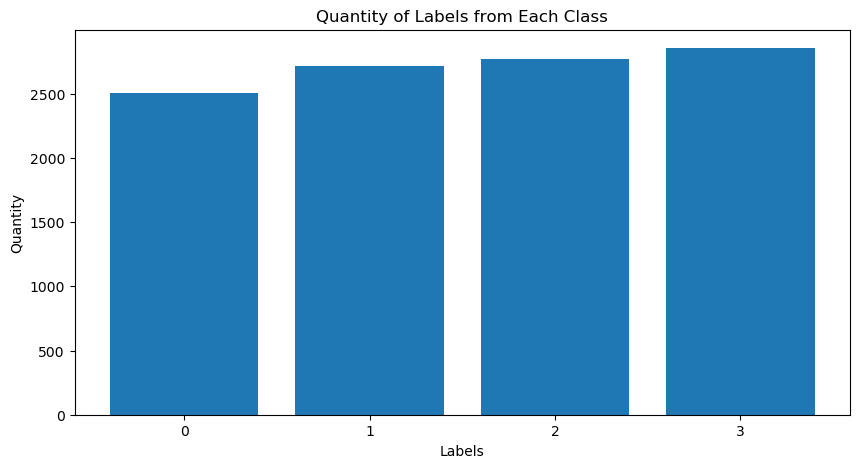

In [3]:
draw_bar_chart(y)

[0 1 2 3]
4


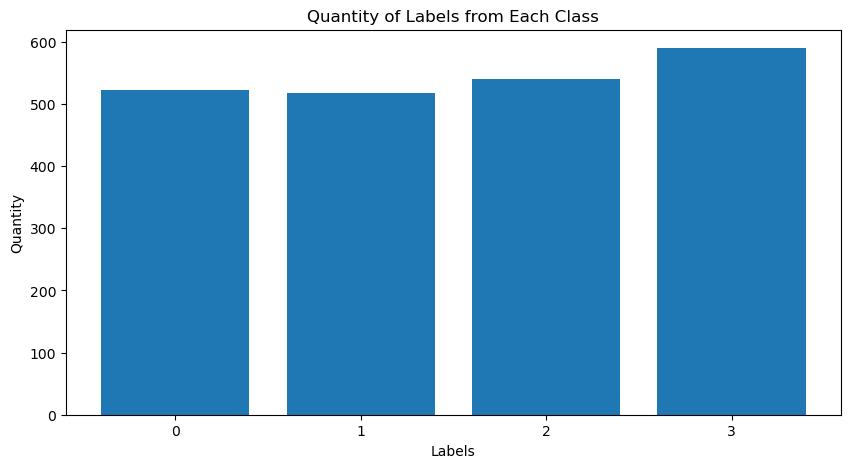

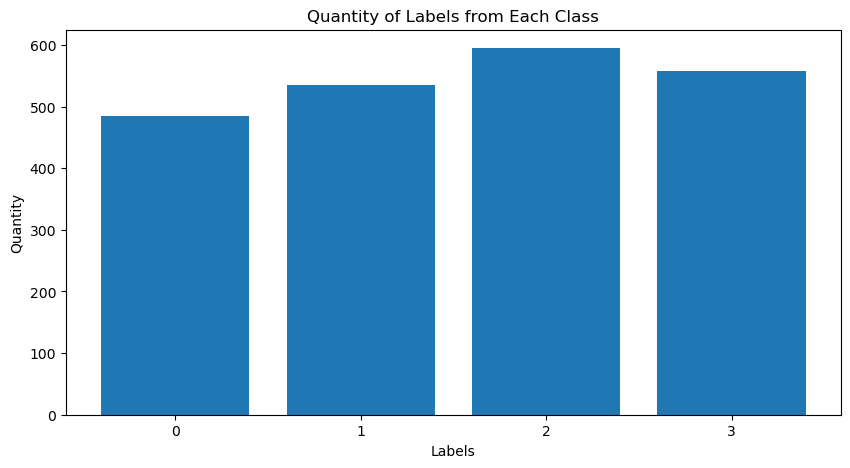

In [4]:
print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

x_train, y_train, x_val, y_val, x_test, y_test = split_and_shuffle(x, y, balanced=False)

draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [5]:
def fc_model(dropout=0.4, learning_rate=0.0001, kernel_size=2, num_conv_layers=2):
   # Create a `Sequential` model and add a Dense layer as the first layer.
   model = tf.keras.models.Sequential()
   model.add(tf.keras.Input(shape=(21,3)))
   for _ in range(num_conv_layers):
      model.add(tf.keras.layers.Conv1D(64, kernel_size, activation='relu'))
   #model.add(tf.keras.layers.MaxPooling1D(2,1))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(128, activation='relu'))
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(32, activation='relu'))
   model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))

   model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["sparse_categorical_accuracy"]
   )
   return model

In [6]:
# learning_rate - 0.01, 0.001, 0.0001
# dropout - 0, 0.1, 0.2, 0.3, 0.4
# kernel size - 2, 3
# conv layers - 1, 2, 3
# 4*4*6*3

In [7]:
#input_shape = x.shape[1:]

model = fc_model()

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=250, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=10000,
    batch_size=128,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2023-06-22 22:29:36.434728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-22 22:29:36.633897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-22 22:29:36.634862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            448       
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            8256      
                                                                 
 flatten (Flatten)           (None, 1216)              0         
                                                                 
 dropout (Dropout)           (None, 1216)              0         
                                                                 
 dense (Dense)               (None, 128)               155776    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4

2023-06-22 22:29:49.569975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-22 22:29:51.494020: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fbc20005340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-22 22:29:51.494168: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-06-22 22:29:53.057865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-22 22:29:55.882103: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 13s 21ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.2615 - val_loss: 1.3772 - val_sparse_categorical_accuracy: 0.3220
Epoch 2/10000
51/51 [==============================] - 0s 6ms/step - loss: 1.3732 - sparse_categorical_accuracy: 0.3181 - val_loss: 1.3541 - val_sparse_categorical_accuracy: 0.3851
Epoch 3/10000
51/51 [==============================] - 0s 6ms/step - loss: 1.3416 - sparse_categorical_accuracy: 0.3719 - val_loss: 1.2991 - val_sparse_categorical_accuracy: 0.4205
Epoch 4/10000
51/51 [==============================] - 0s 6ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.3865 - val_loss: 1.2630 - val_sparse_categorical_accuracy: 0.4146
Epoch 5/10000
51/51 [==============================] - 0s 6ms/step - loss: 1.2751 - sparse_categorical_accuracy: 0.4064 - val_loss: 1.2343 - val_sparse_categorical_accuracy: 0.4376
Epoch 6/10000
51/51 [==============================] - 0s 6ms/step - loss: 1.2472 - sparse_categorical_accu

[0.22363229095935822, 0.9419889450073242]

In [8]:
# maior early stopping, dropout, matriz de confusao, alterar batch size, alterar kernel size, transformers

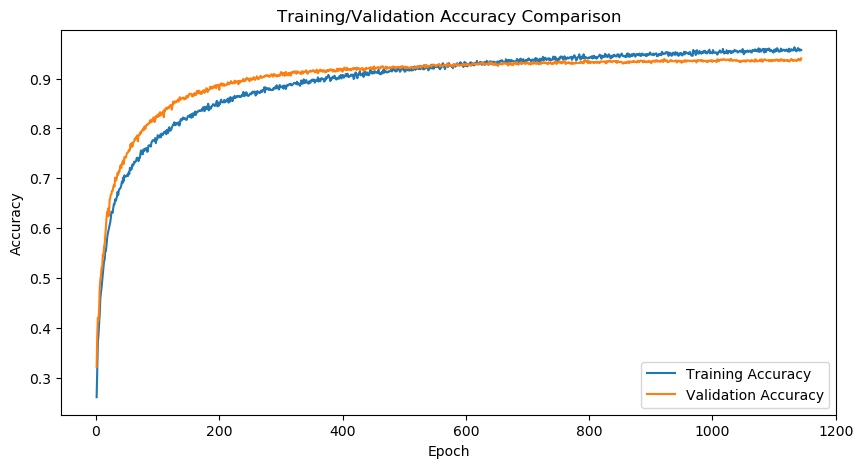

In [9]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

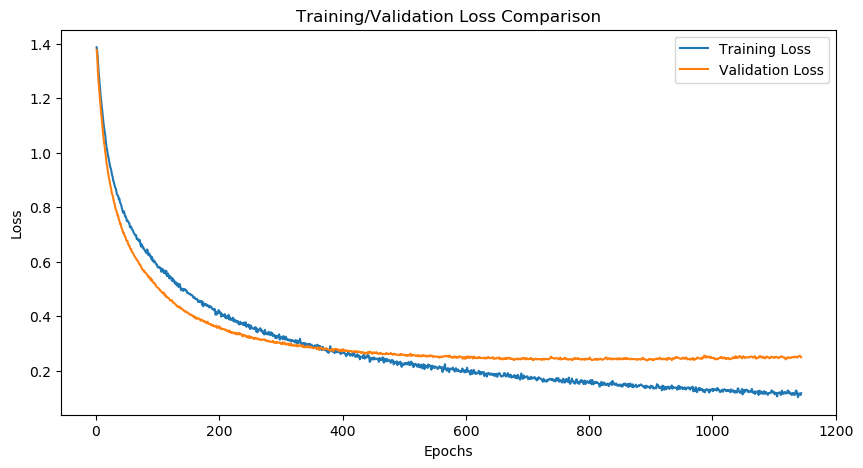

In [10]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

68/68 [==============================] - 0s 2ms/step


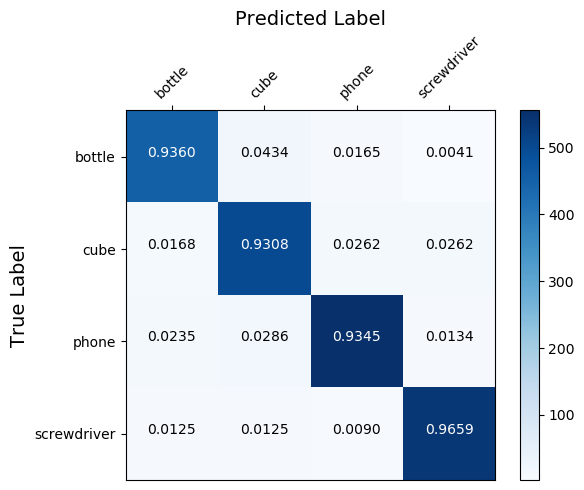

In [11]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "phone", "screwdriver"])

In [12]:
# dropouts=[0.1 * _ for _ in range(6)]
# acc = []
# loss = []

# for d in dropouts:
#     model = fc_model(dropout=d)

#     model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         metrics=["sparse_categorical_accuracy"]
#     )

#     callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

#     results = model.fit(
#         x_train,
#         y_train,
#         validation_data=(x_val,y_val),
#         #validation_split=0.2,
#         epochs=100,
#         batch_size=16,
#         callbacks=callbacks,
#     )

#     acc.append(results.history["val_sparse_categorical_accuracy"])
#     loss.append(results.history["val_loss"])

In [13]:
# plot_accuracy_comparison(acc, "Dropout Comparison (Validation Accuracy)", dropouts)


In [14]:
# plot_loss_comparison(loss, "Dropout Comparison (Validation Loss)", dropouts)

In [15]:
# #a = np.array([0,1,0,0,1,0,0,1,0,0])
# #a = np.array([1,1,0,1,1,0,1,1,0,1])
# #a = np.array([2,2,0,2,2,1,2,2,3,2])
# a = np.array([7,7,0,7,7,3,7,7,6,7])

# a = a.reshape((1, a.shape[0],1))

# print(a.shape)

# model.predict(a)

In [18]:
# model.save('../models/points_conv_1d')

2023-06-22 22:36:30.352939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1216]
	 [[{{node inputs}}]]
2023-06-22 22:36:30.372329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-06-22 22:36:30.761391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1216]
	 [[{{node inputs}}]]
2023-06-22 22:

INFO:tensorflow:Assets written to: ../models/points_conv_1d/assets


INFO:tensorflow:Assets written to: ../models/points_conv_1d/assets


In [17]:
#model = tf.keras.models.load_model('../models/transformer_numbers')